In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
import shapely
import missingno as msn
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from matplotlib import animation

In [2]:
df=pd.read_csv('AISData.csv')
gdf = gpd.GeoDataFrame(df.drop(['location.coordinates.0', 'location.coordinates.1'], axis=1),
crs={'init': 'epsg:4326'},
geometry=[shapely.geometry.Point(xy) for xy in zip(df['location.coordinates.0'], df['location.coordinates.1'])])

In [3]:
# Print the AIS data
gdf

,Unnamed: 0,event_time,position_accuracy,mmsi,sog,cog,geometry
0,0,2019-04-11T09:47:30.153Z,0.0,316013808,3.0,319.500000,POINT (-63.55608166666666 44.624835)
1,1,2019-04-11T09:47:27.273Z,0.0,316013808,3.0,320.700012,POINT (-63.55605333333333 44.62481666666667)
2,2,2019-04-11T09:47:34.340Z,0.0,316013808,2.9,319.500000,POINT (-63.55613833333334 44.62486833333333)
3,3,2019-04-11T09:47:37.087Z,0.0,316013808,3.0,319.799988,POINT (-63.55618666666667 44.62489833333333)
4,4,2019-04-19T09:52:19.358Z,0.0,316013808,3.2,337.200012,POINT (-63.55599833333334 44.62488333333334)
5,5,2019-04-19T09:52:19.358Z,0.0,316013808,3.2,337.200012,POINT (-63.55599833333334 44.62488333333334)
6,6,2019-05-25T19:40:53.826Z,0.0,316013808,1.5,168.399994,POINT (-63.55596666666667 44.62499833333333)
7,7,2019-05-21T21:39:50.762Z,0.0,316013808,4.3,134.600006,POINT (-63.55597666666666 44.62504833333333)
8,8,2019-04-09T10:13:59.833Z,0.0,316013808,3.9,312.399994,POINT (-63.55591833333333 44.62511833333333)
9,9,2019-04-09T10:13:55.860Z,0.0,316013808,4.3,310.600006,POINT (-63.555845 44.62507166666666)


In [4]:
nima_ports=gpd.read_file('assignment3shapefile.shp')
print(nima_ports)
nima_ports=nima_ports.set_index(['port_name'])
ports_without_buffer = nima_ports

    field_1                    port_name    size  \
0         0                 pointpolygon  0.0000   
1         1                        port1  0.0018   
2         2                        port2  0.0018   
3         3                          ind  0.0000   
4         4                        port5  0.0018   
5         5                        port6  0.0018   
6         6                        port7  0.0018   
7         7              south_enterance  0.0000   
8         8                    auto_port  0.0015   
9         9  southend container terminal  0.0050   
10       10                     NN Jetty  0.0020   
11       11                 Bills island  0.0020   
12       12                  mid bedford  0.0040   
13       13                Fairview cove  0.0040   
14       14                     armament  0.0020   
15       15                 waterfront h  0.0020   
16       16                     northarm  0.0020   
17       17                         plll  0.0015   
18       18 

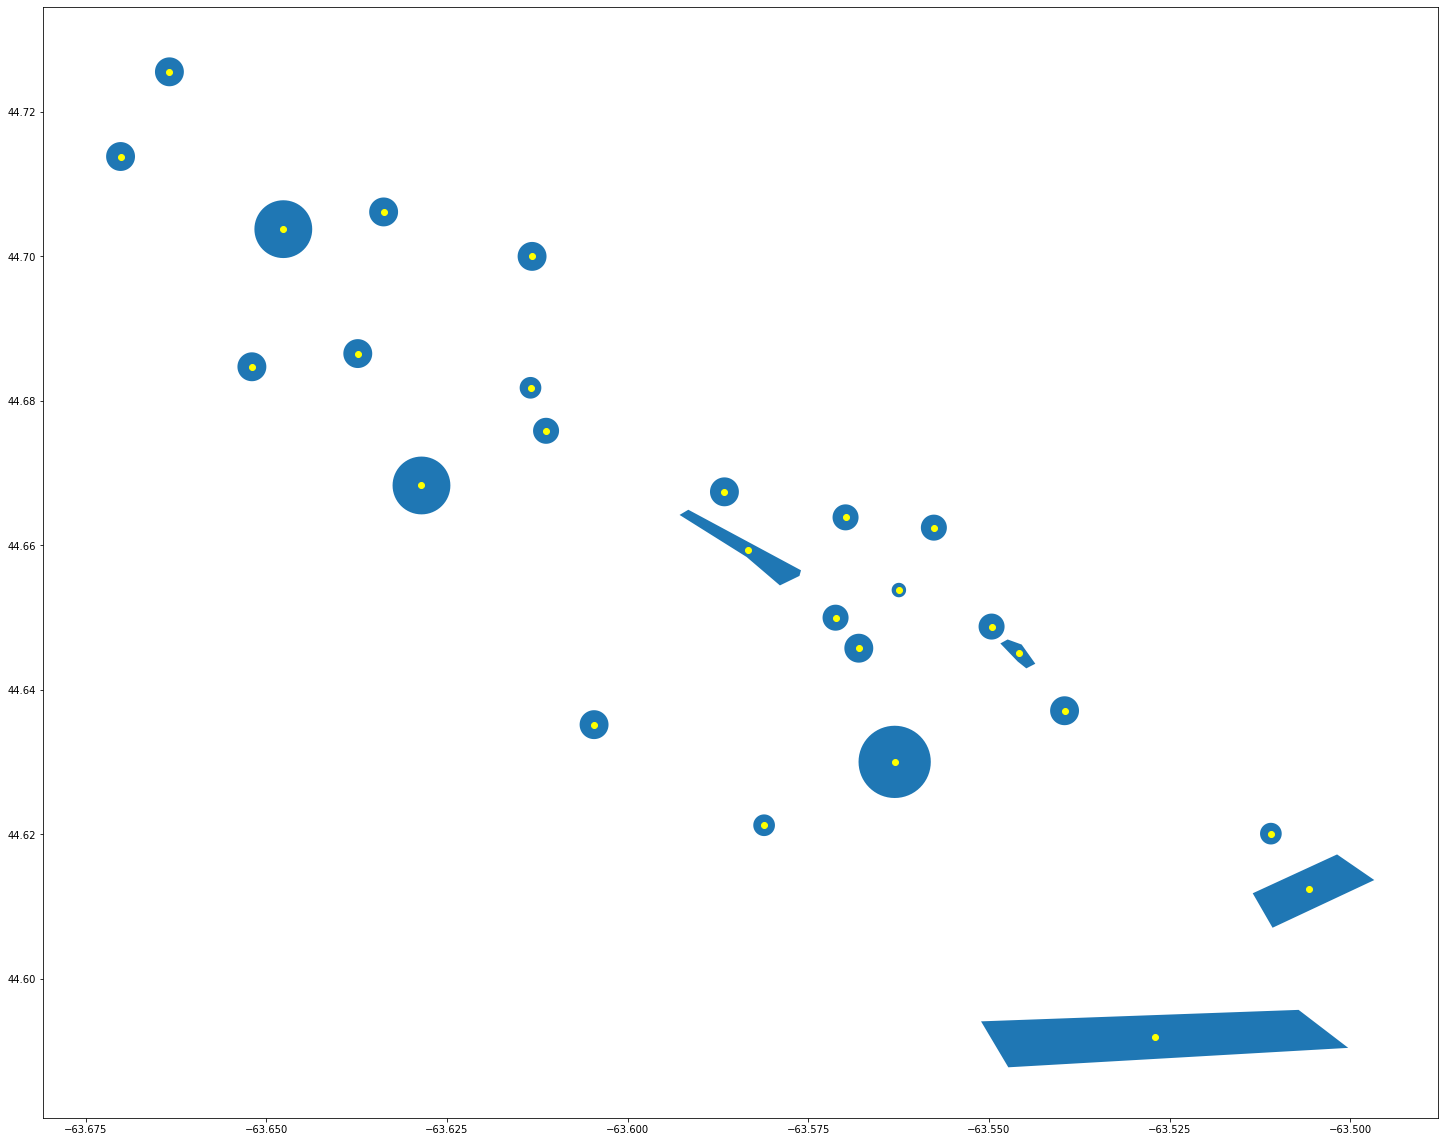

In [5]:
# Plot port data without buffers
centers = nima_ports.centroid
ax = nima_ports.plot(figsize=(25,25))
gpd.GeoSeries(centers).plot(ax=ax,color='yellow')

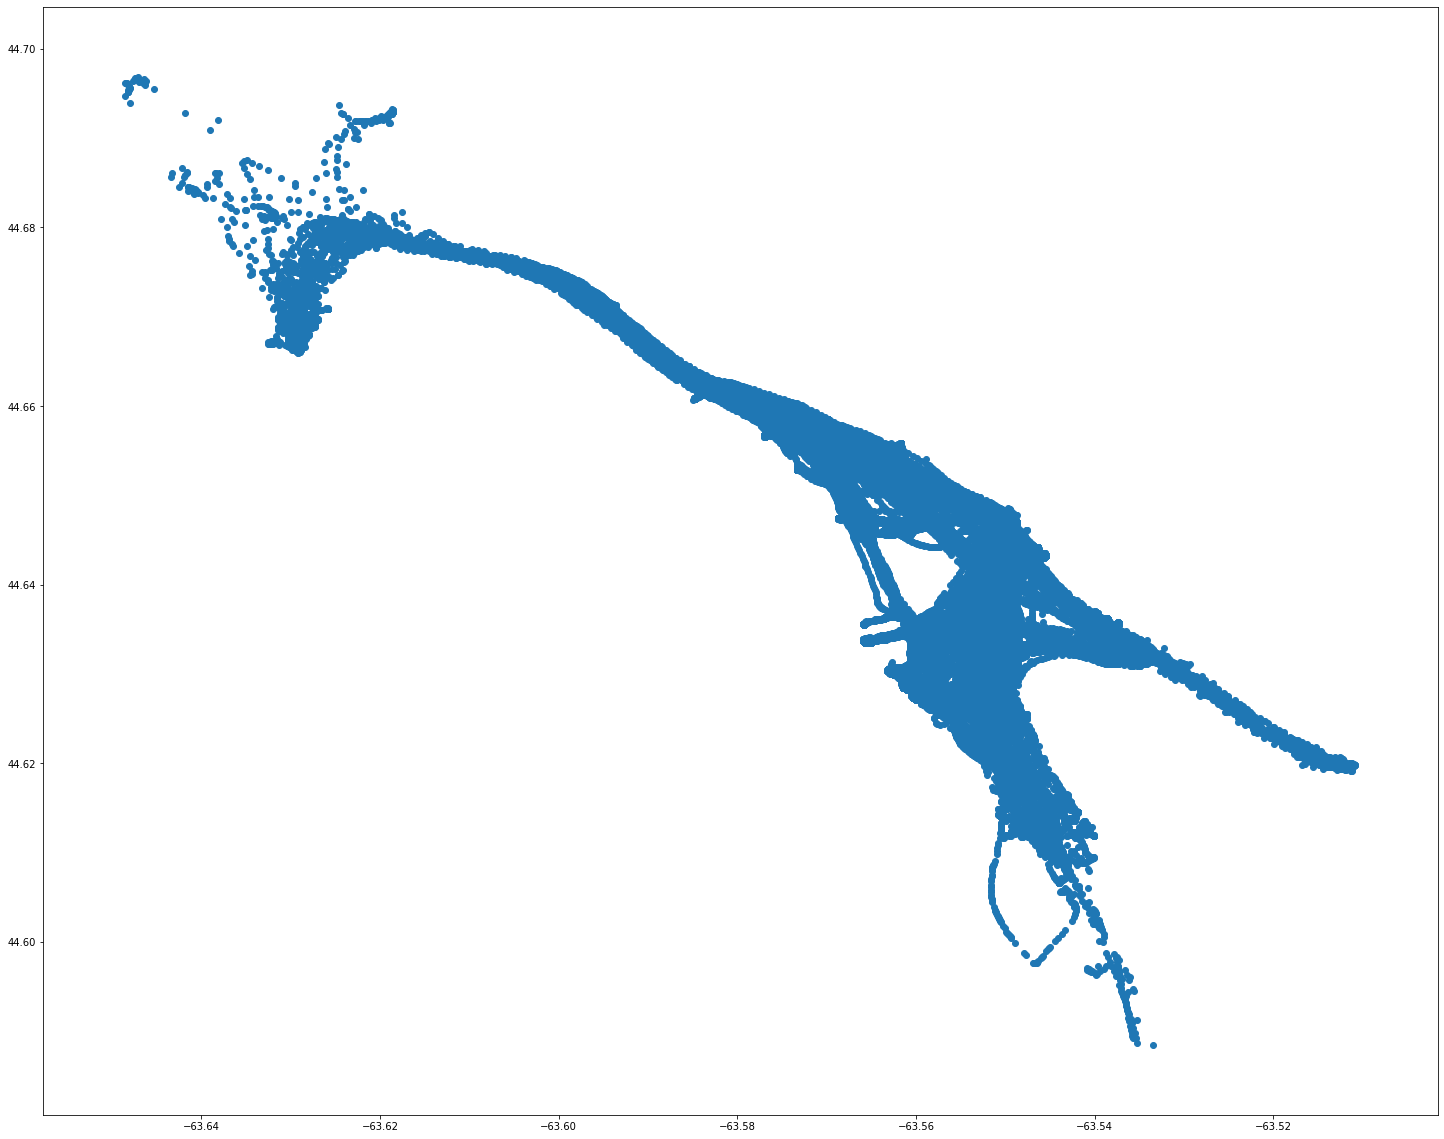

In [6]:
# AIS messages plot
gdf.plot(figsize=(25,25))

# Q1

In the first part a buffer is created around the ports and later the messages that intersect the port buffers are plotted in red. 

The AIS messages and port data are combined using the Geopandas spatial join as shown below.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {})
  '(%s != %s)' % (left_df.crs, right_df.crs))


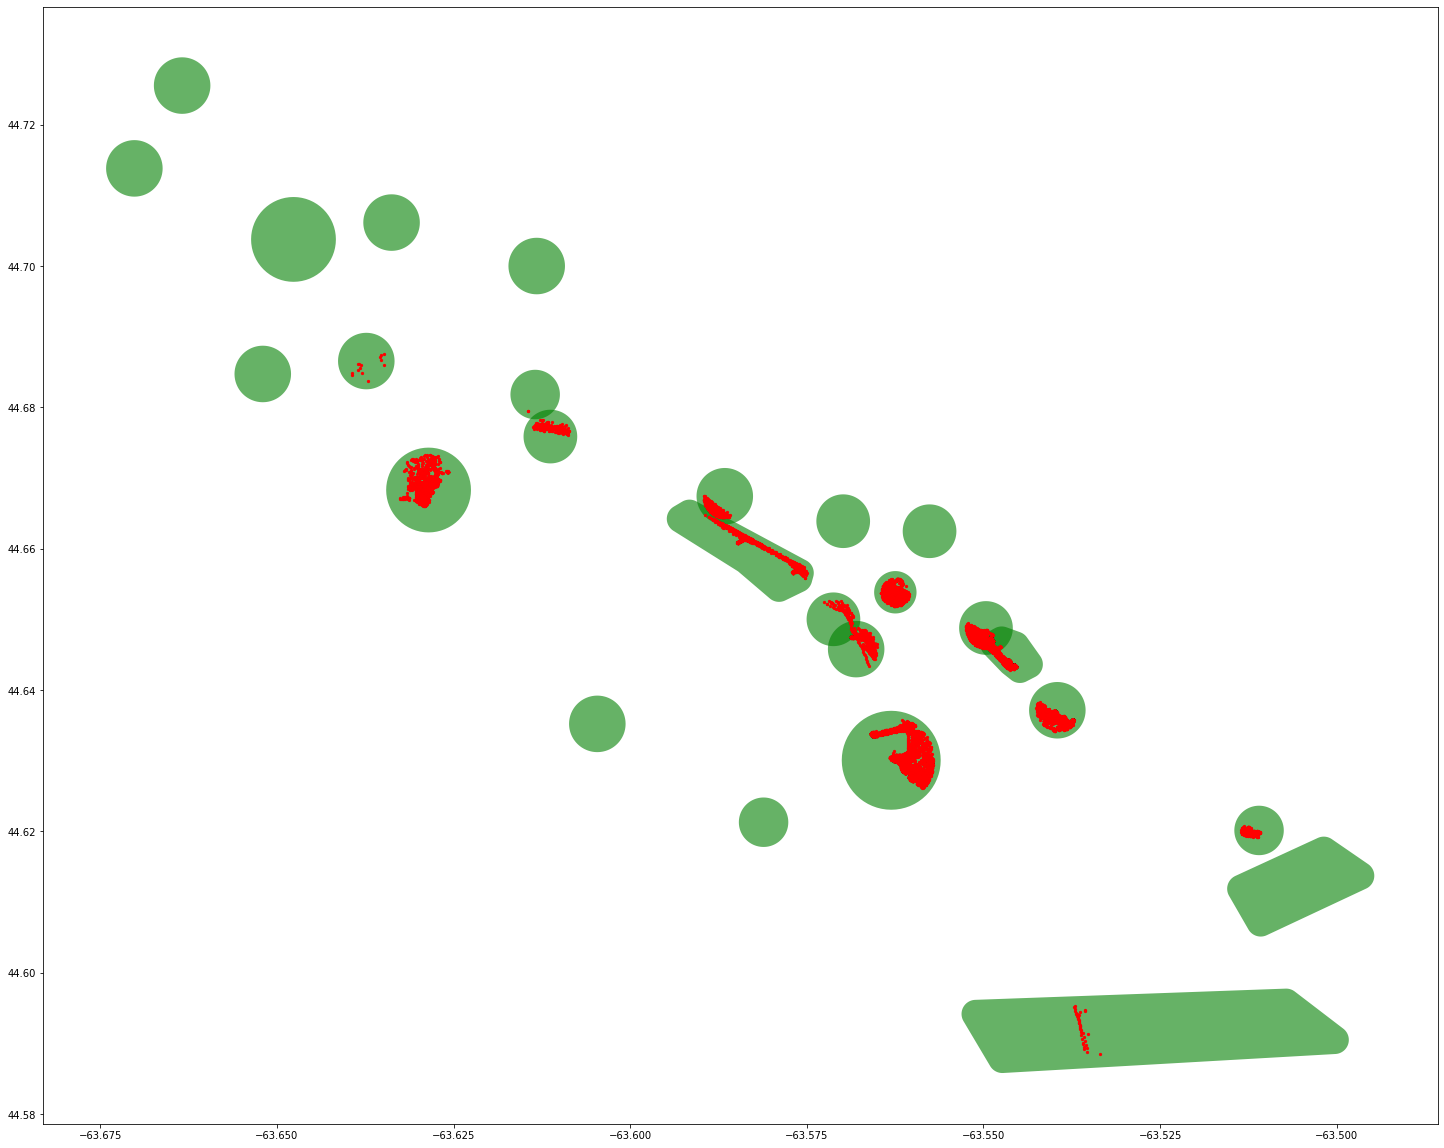

In [7]:
# Create a buffer and show the intersection of ship messages with ports 
nima_ports['geometry'] = nima_ports['geometry'].buffer(0.001)
ax2 = nima_ports.buffer(0.001).plot(figsize=(25,25), color='g', alpha=0.6)

joinres=gpd.sjoin(gdf,nima_ports,op='intersects',how='inner')
joinres.plot(ax=ax2, color='r', markersize=5)

# Question 2

Each port has a message density based on the mesasges sent by different vessels. In order to highlight the number of messages in a given port, I have used a color coding scheme.

The color coding scheme for messages to a port is given by:
* Orange if the number of messages lies between 1-230
* Blue if the number of messages lies between 230-1500
* Green if the number of messages is greater than 1500
* Black if there were no messages received


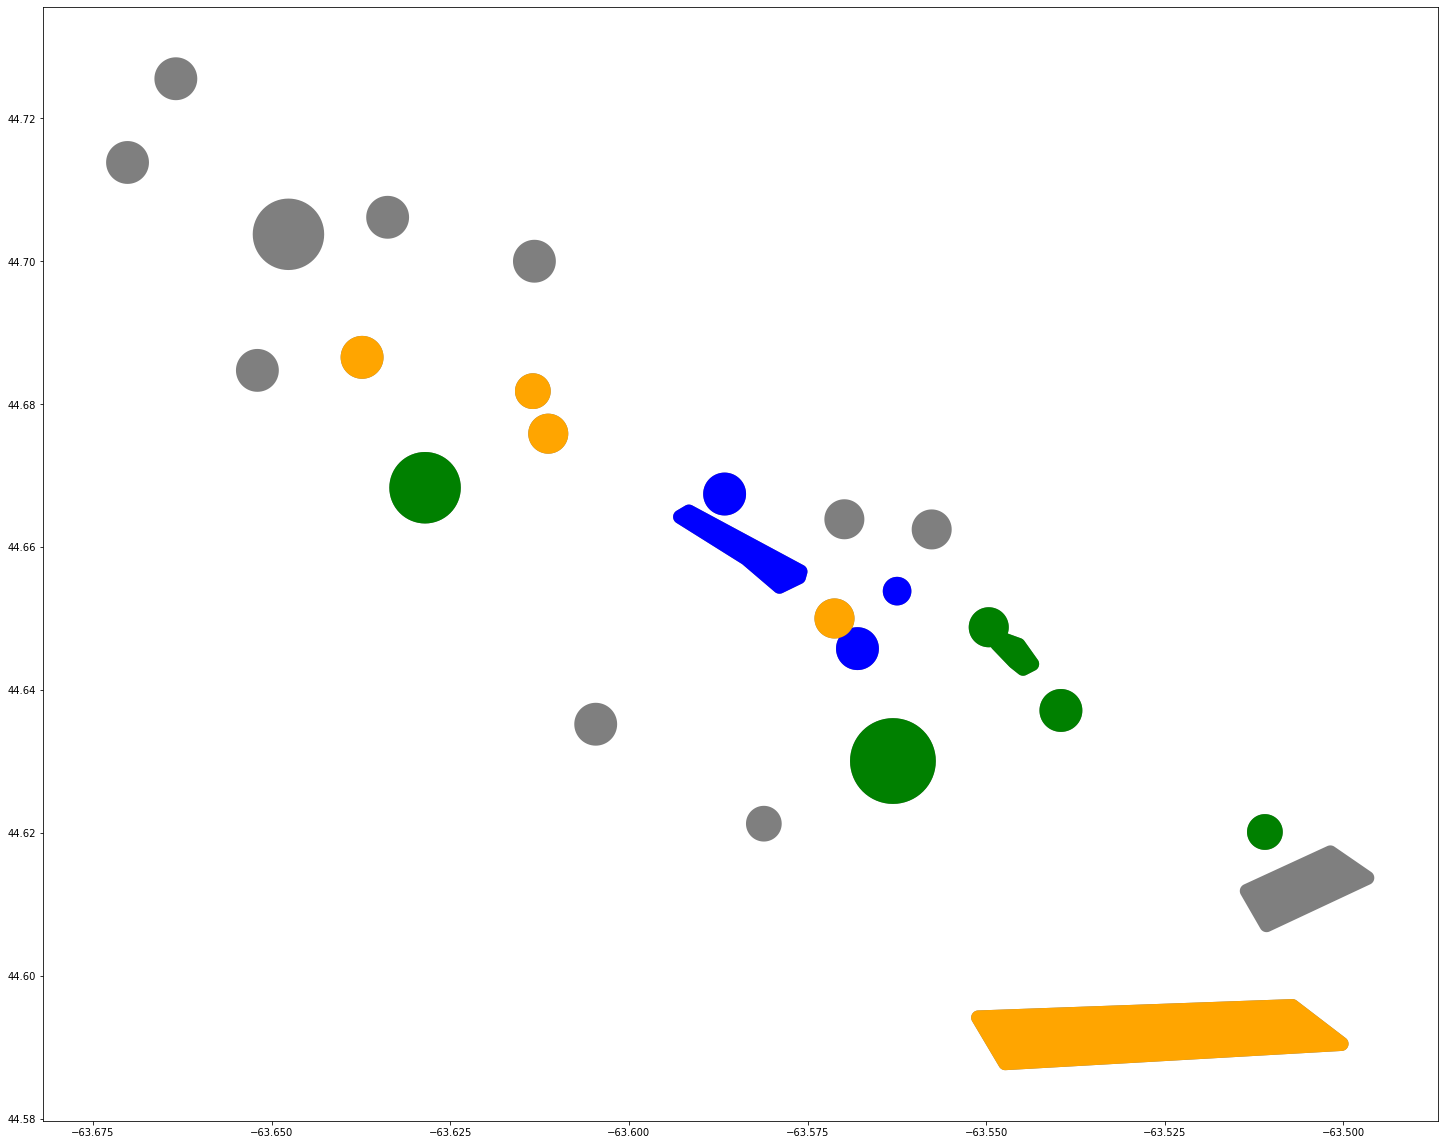

In [16]:
port_count = joinres['index_right'].value_counts()
ax = ports_without_buffer.plot(figsize= (25,25), color='black', alpha=0.5)

def get_color(i):
    if(i < 230 and i>0):
        color='orange'
    elif(i >= 230 and i <=1500):
        color='blue'
    elif(i > 1500):
        color='green'
    return color

for i in range(len(port_count)):
    color = get_color(port_count[i])
    ports_without_buffer[ports_without_buffer.index == port_count.index[i]]['geometry'].plot(ax=ax, color=color)


# Question 3

The entire dataset is divided into one hour intervals and the vessel message plots are made. The plots are stored in a folder called <b>"images"</b> in the current directory and each image has the following naming convention:


<b>Figure number/hour</b> 

The figure number is just a reference to show the number of figures and the hour specifies the message density at a particular hour.

In [10]:
date_obj = pd.to_datetime(joinres['event_time'], utc=True)
list_split_by_hour = [g.reset_index(drop=True) for i,g in joinres.groupby([date_obj.dt.date,date_obj.dt.hour])]

In [11]:
len(list_split_by_hour)

2513

In [12]:
list_split_by_hour[1]

,Unnamed: 0,event_time,position_accuracy,mmsi,sog,cog,geometry,index_right,field_1,size
0,849,2019-03-05T22:02:48.910Z,NaN,316013808,NaN,NaN,POINT (-63.58930166666666 44.66671166666666),armament,14,0.002
1,1082,2019-03-05T22:02:40.430Z,NaN,316013808,NaN,NaN,POINT (-63.58884166666667 44.66639166666667),armament,14,0.002
2,1600,2019-03-05T22:02:10.083Z,NaN,316013808,NaN,NaN,POINT (-63.58712 44.6652),armament,14,0.002
3,1625,2019-03-05T22:02:00.163Z,NaN,316013808,NaN,NaN,POINT (-63.58653166666666 44.664825),armament,14,0.002
4,1991,2019-03-05T22:27:17.176Z,NaN,316013808,NaN,NaN,POINT (-63.62809666666666 44.66979833333333),Fairview cove,13,0.004
5,2012,2019-03-05T22:22:39.523Z,NaN,316013808,NaN,NaN,POINT (-63.62778833333334 44.67025833333334),Fairview cove,13,0.004


In [13]:
# import os
# import errno

# filename = "./images"
# os.makedirs(filename, exist_ok=True)

# for i in range(len(list_split_by_hour)):
#     ax2 = nima_ports.buffer(0.001).plot(figsize=(25,25), color='g', alpha=0.6)
#     fig = list_split_by_hour[i].plot(figsize=(25,25), ax=ax2).get_figure()
#     plt.savefig("{0}/Figure {1}:{2}.png".format(filename,i,list_split_by_hour[i]['event_time'].str.split('T').iloc[0][1].split(':')[0]))
        

# Question 4

I have selected the port "auto_port" and I have first filtered all the AIS messages using the dataframe obtained from the sjoin operation in step 2. Also, from step 3, I have split the messages into one hour intervals for auto_port and I have calculated the number of messages by just taking the length of each of the dataframe for one hour intervals.


In the plot below, the y-axis shows the density of messages on an hourly basis on different days, whereas the x-axis shows the timestamps in the follwoing format: <b>date/hour:</b>. The date part represents the day on which the messages were intercepted and the hour provides the hour at which the message was intercepted on that particular day.

In [22]:
auto_port = joinres[joinres['index_right'] == 'auto_port']

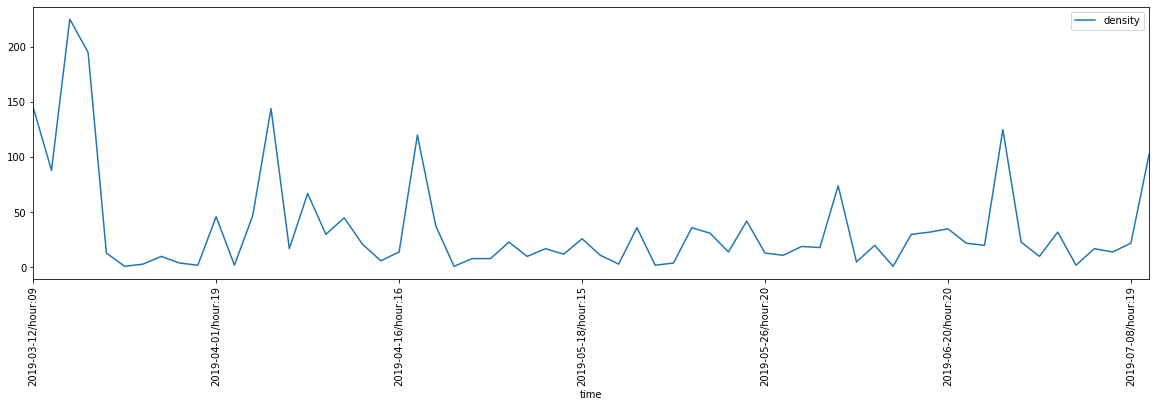

In [60]:
date_obj = pd.to_datetime(auto_port['event_time'], utc=True)
port_list_split_by_hour = [g for i,g in auto_port.groupby([date_obj.dt.date,date_obj.dt.hour])]
density_plot = pd.DataFrame(columns = ['time', 'density'])
for i in range(len(port_list_split_by_hour)):
    density_plot.at[i,'density'] = len(port_list_split_by_hour[i])
    density_plot.at[i,'time'] = port_list_split_by_hour[i]['event_time'].str.split('T').iloc[0][0] + "/hour:" + port_list_split_by_hour[i]['event_time'].str.split('T').iloc[0][1].split(':')[0]

density_plot.plot(x='time', y='density', figsize=(20,5)) 
plt.xticks(rotation=90)
plt.show()

# Question 5